In [1]:
# import sqlite3

# conn = sqlite3.connect("quotations.db")
# cursor = conn.cursor()

# cursor.execute("DROP TABLE IF EXISTS TrainingQuotation")
# conn.commit()
# conn.close()

# print("Tabela TrainingQuotation apagada com sucesso.")


In [2]:
import pandas as pd
import sqlite3

# Caminho para seu banco de dados
conn = sqlite3.connect("../data/quotations.db")

# Lendo a tabela com os dados de treino
df = pd.read_sql_query("SELECT * FROM training_quotations", conn)
df_test = pd.read_sql_query("SELECT * FROM real_quotation_data", conn)
conn.close()

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10000 non-null  int64  
 1   unit_price            10000 non-null  float64
 2   delivery_days         10000 non-null  int64  
 3   performance_score     10000 non-null  float64
 4   response_time         10000 non-null  float64
 5   rfq_complexity_score  10000 non-null  float64
 6   is_urgent             10000 non-null  int64  
 7   is_custom             10000 non-null  int64  
 8   won                   10000 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 703.3 KB


In [4]:
df.head()

,id,unit_price,delivery_days,performance_score,response_time,rfq_complexity_score,is_urgent,is_custom,won
0,1,10.25,5,4.45,65.12,3.24,0,0,0
1,2,12.02,9,4.16,28.02,2.76,0,0,0
2,3,10.99,3,4.20,6.08,2.71,0,0,1
3,4,10.37,5,3.15,60.32,3.01,0,0,0
4,5,8.40,8,3.35,49.39,3.05,0,0,0


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    511 non-null    int64  
 1   unit_price            511 non-null    float64
 2   delivery_days         511 non-null    int64  
 3   performance_score     511 non-null    float64
 4   response_time         511 non-null    float64
 5   rfq_complexity_score  511 non-null    float64
 6   is_urgent             511 non-null    int64  
 7   is_custom             511 non-null    int64  
 8   won                   0 non-null      object 
dtypes: float64(4), int64(4), object(1)
memory usage: 36.1+ KB


In [6]:
df_test.head()

,id,unit_price,delivery_days,performance_score,response_time,rfq_complexity_score,is_urgent,is_custom,won
0,1,9.71,6,3.53,2.0,2.82,1,0,None
1,2,10.40,5,4.05,2.0,3.23,0,0,None
2,3,12.41,7,4.81,2.0,2.71,0,0,None
3,4,10.92,8,3.84,2.0,3.25,0,0,None
4,5,12.37,7,3.88,2.0,3.20,0,0,None


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

# Define feature and target columns
binary_columns = ['is_urgent', 'is_custom']
non_binary_columns = ['unit_price', 'delivery_days', 'performance_score', 'response_time', 'rfq_complexity_score']

X = df.drop(columns=['id', 'won'])
y = df['won']

# Train-validation split
X_train_full, X_val_full, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Undersample only the training set
undersampler = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = undersampler.fit_resample(X_train_full, y_train)

# Apply MinMaxScaler only on non-binary columns
scaler = MinMaxScaler()
X_train_us_scaled = X_train_us.copy()
X_val_scaled = X_val_full.copy()

X_train_us_scaled[non_binary_columns] = scaler.fit_transform(X_train_us[non_binary_columns])
X_val_scaled[non_binary_columns] = scaler.transform(X_val_full[non_binary_columns])

# Store raw (unscaled) versions for tree-based models
X_train_us_raw = X_train_us.copy()
X_val_raw = X_val_full.copy()




In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Define models and data
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "X_train": X_train_us_scaled,
        "X_val": X_val_scaled,
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "X_train": X_train_us_raw,
        "X_val": X_val_raw,
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric="logloss", random_state=42),
        "X_train": X_train_us_raw,
        "X_val": X_val_raw,
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1),
        "X_train": X_train_us_raw,
        "X_val": X_val_raw,
    }
}

# Train and evaluate each model
for name, config in models.items():
    model = config["model"]
    X_train = config["X_train"]
    X_val = config["X_val"]

    print(f"\n🔹 {name}")
    model.fit(X_train, y_train_us)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    print("Training classification report:")
    print(classification_report(y_train_us, y_train_pred))

    print("Validation classification report:")
    print(classification_report(y_val, y_val_pred))



🔹 Logistic Regression
Training classification report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1010
           1       0.84      0.92      0.88      1010

    accuracy                           0.87      2020
   macro avg       0.87      0.87      0.87      2020
weighted avg       0.87      0.87      0.87      2020

Validation classification report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1748
           1       0.43      0.93      0.58       252

    accuracy                           0.83      2000
   macro avg       0.71      0.87      0.74      2000
weighted avg       0.92      0.83      0.86      2000


🔹 Random Forest
Training classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1010
           1       1.00      1.00      1.00      1010

    accuracy                           1.00 

The **F1-score** is selected as the **primary evaluation metric** because it balances precision and recall, which are both critical in the quotation acceptance prediction task. This metric captures the trade-off between false positives and false negatives, providing a more comprehensive assessment of model performance than accuracy alone, especially given the inherent class imbalance in the quotation acceptance problem

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create base model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_us_scaled, y_train_us)

# Print best hyperparameters and training F1 score
print("Best parameters:", grid_search.best_params_)
print("Best F1 score on training set (cross-validated):", grid_search.best_score_)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_

# Predictions on training and validation sets
y_pred_train = best_model.predict(X_train_us_scaled)
y_pred_val = best_model.predict(X_val_scaled)

# Print classification reports
print("\nClassification Report (Train):")
print(classification_report(y_train_us, y_pred_train))

print("Classification Report (Validation):")
print(classification_report(y_val, y_pred_val))



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score on training set (cross-validated): 0.876383723573338

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1010
           1       0.84      0.92      0.88      1010

    accuracy                           0.87      2020
   macro avg       0.88      0.87      0.87      2020
weighted avg       0.88      0.87      0.87      2020

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1748
           1       0.43      0.93      0.59       252

    accuracy                           0.84      2000
   macro avg       0.71      0.88      0.74      2000
weighted avg       0.92      0.84      0.86      2000



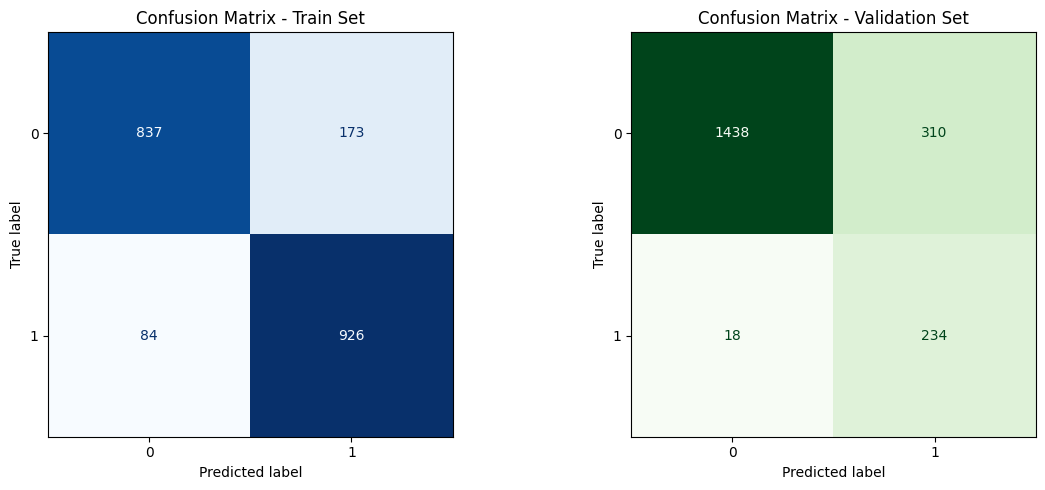

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train predictions
y_train_pred = best_model.predict(X_train_us_scaled)
y_val_pred = best_model.predict(X_val_scaled)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_train_us, y_train_pred, ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Confusion Matrix - Train Set")

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, ax=ax[1], cmap="Greens", colorbar=False)
ax[1].set_title("Confusion Matrix - Validation Set")

plt.tight_layout()
plt.show()


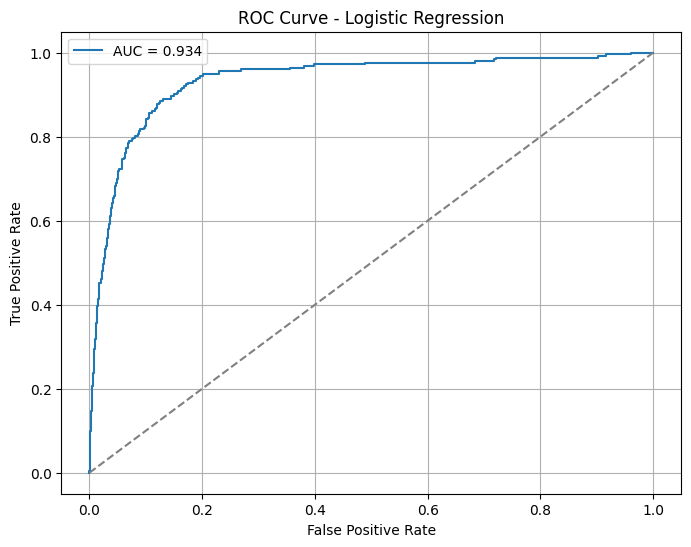

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

best_model = grid_search.best_estimator_
y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_val, y_val_proba)
auc_score = roc_auc_score(y_val, y_val_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import numpy as np

# Extract and display coefficients
coefs = best_model.coef_[0]
features = X_train_us_scaled.columns
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefs
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

print("🔍 Logistic Regression - Feature Importance (sorted by magnitude):")
print(coef_df[['Feature', 'Coefficient']])


🔍 Logistic Regression - Feature Importance (sorted by magnitude):
                Feature  Coefficient
3         response_time    -8.190163
0            unit_price    -2.098221
5             is_urgent    -1.808071
2     performance_score     1.241760
1         delivery_days    -0.717280
4  rfq_complexity_score    -0.487875
6             is_custom     0.259879


C:\Users\lucas\AppData\Local\Temp\ipykernel_22356\3572712529.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.head(10), x='Coefficient', y='Feature', palette='coolwarm')


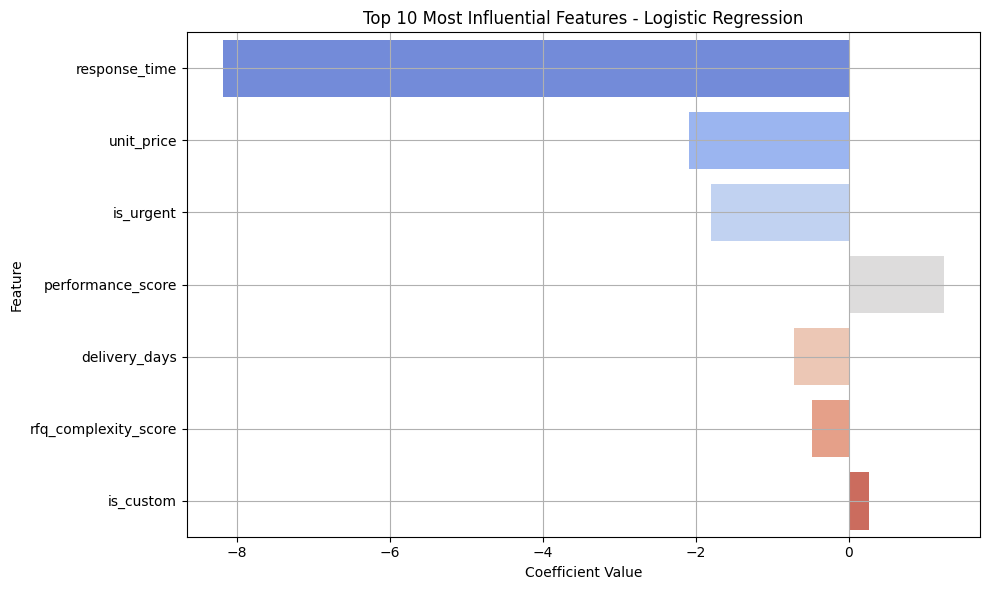

In [16]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=coef_df.head(10), x='Coefficient', y='Feature', palette='coolwarm')
plt.title("Top 10 Most Influential Features - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
import joblib
import os

models_dir = "../models/"
os.makedirs(models_dir, exist_ok=True)

# Save model and scaler in the .src/models/ folder
joblib.dump(best_model, os.path.join(models_dir, "best_logistic_model.pkl"))
joblib.dump(scaler, os.path.join(models_dir, "minmax_scaler.pkl"))

print("✅ Model and scaler saved successfully in .src/models/")



✅ Model and scaler saved successfully in .src/models/


TEST

In [38]:
# Copy test data (with all features, 'won' is null)
df_test_copy = df_test.copy()

# Ensure the same column order and names
X_test = df_test_copy.drop(columns=['id', 'won'])

# Apply same MinMax scaling only to non-binary columns
X_test_scaled = X_test.copy()
X_test_scaled[non_binary_columns] = scaler.transform(X_test[non_binary_columns])

# Obter probabilidades de aceitação (classe 1)
test_probabilities = best_model.predict_proba(X_test_scaled)[:, 1]

# Inserir scores de aceitação no dataframe
df_test_copy['won'] = test_probabilities



In [39]:
df_test_copy.sample(5)

,id,unit_price,delivery_days,performance_score,response_time,rfq_complexity_score,is_urgent,is_custom,won
191,192,2.68,5,3.58,2.0,3.00,0,0,0.927809
323,324,0.96,3,3.58,2.0,1.92,0,0,0.952890
346,347,2.89,5,4.98,2.0,2.02,0,0,0.948846
88,89,0.28,3,3.49,2.0,2.81,0,0,0.948364
274,275,2.95,9,3.21,2.0,2.18,0,0,0.918633


In [ ]:
import sqlite3

# Reopen connection to the database
conn = sqlite3.connect("../data/quotations.db")

# Overwrite the table with the updated data
df_test_copy.to_sql("real_quotation_data", conn, if_exists="replace", index=False)

# Close the connection
conn.close()

print("Table 'real_quotation_data' successfully updated in the database.")


Table 'real_quotation_data' successfully updated in the database.


In [ ]:
import sqlite3
sqlite3.connect("../data/quotations.db").close()
